<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw2/blob/main/nndl_2020__homework_2_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PART 0 Preparing dataset and classes






## Get dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet optuna


In [3]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import notebook, tqdm # this module is useful to plot progress bars
from sklearn.decomposition import PCA
import json

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import torchvision
import optuna

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Training device: cuda


get notMNIST dataset from repo
It is the small version

In [38]:
! git clone https://github.com/DanieleFoscarin/NNDL_hw2.git

fatal: destination path 'NNDL_hw2' already exists and is not an empty directory.


In [39]:
! tar xzf  /content/NNDL_hw2/notMNIST_small.tar.gz

Read the folders

In [4]:
ROOT = '/content/notMNIST_small' 
from pathlib import Path
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

images = []
labels = []

#there are few broken files that cannot be read
#not a big problem since they are 5 over 500k
num_label = 0
for folder in sorted(Path(ROOT).iterdir()):
  print(folder)
  for f in folder.iterdir():
    try:     
      img = Image.open(f)
      img_array = np.asarray(img)
      images.append(img_array)
      labels.append(num_label)
    except:
      print("a file was not recognized")
  num_label+=1


images_arr = np.float32(np.array(images))
labels_arr = np.float32(np.array(labels))

#normalize images range
images_arr = images_arr/255

#free up some memory
del images

/content/notMNIST_small/A
a file was not recognized
/content/notMNIST_small/B
/content/notMNIST_small/C
/content/notMNIST_small/D
/content/notMNIST_small/E
/content/notMNIST_small/F
a file was not recognized
/content/notMNIST_small/G
/content/notMNIST_small/H
/content/notMNIST_small/I
/content/notMNIST_small/J


Dictionary for easy interpreation of the labels

In [5]:
letter = {0: 'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}
print(letter[6])

G


In [6]:
### Set the random seed for reproducible results
torch.manual_seed(0)

Extend class Dataset

In [7]:
class NMDataset(Dataset):

    def __init__(self, image, label, transform=None):
        self.transform = transform
        self.image = image
        self.label = label

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        this_image = self.image[idx]
        this_label = self.label[idx]
        sample = [this_image, this_label]
        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample


    class ToTensor(object):
        """Convert sample to Tensors."""

        def __call__(self, sample):
            x, y = sample
            return (torch.tensor([x]).float(),
                    torch.tensor([y]).float())

to_tensor = torchvision.transforms.ToTensor()   
# composed_transform = transforms.Compose([ToTensor()])
dataset = NMDataset(images_arr, labels_arr, transform=to_tensor)

#check correctness
out = dataset.__getitem__(0)
print(labels_arr[0])


0.0


Split dataset in train, validation, test

In [8]:
length = dataset.__len__()
testval_size = int(np.ceil(length*0.4))
train_size = int(length-testval_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, testval_size])

test_size = int(np.ceil(test_dataset.__len__()*0.5))
val_size = int(test_dataset.__len__()-test_size)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

print(f"train_dataset length {train_dataset.__len__()}")
print(f"val_dataset length {val_dataset.__len__()}")
print(f"test_dataset length {test_dataset.__len__()}")
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset length 11234
val_dataset length 3745
test_dataset length 3745


Show example of the dataset

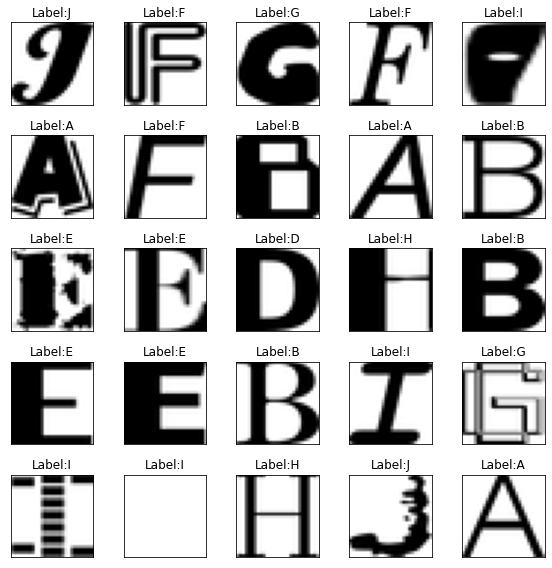

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(test_dataset)
    img = img.numpy().squeeze()
    ax.imshow(np.array(img), cmap='gray_r')
    ax.set_title(f'Label:{letter[label]}' )
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Autoencoder Classes

In [13]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1_ch, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(conv1_ch, conv2_ch, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(conv2_ch, conv3_ch, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * conv3_ch, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, 3 * 3 * conv3_ch),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3_ch, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3_ch, conv2_ch, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2_ch, conv1_ch, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1_ch, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## Training preparation

function for a single epoch training

In [14]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    
    return loss.data

function for a single epoch inference

In [15]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

# Part 1 base Autoencoder

## Parameters search with Optuna

we need to put the training loop in the level of the objective function, and not as another function, in order to have a functioning trial.report used for pruning

In [ ]:
def objective(trial):

    #suggest parameters
    encoded_space_dim = trial.suggest_int('encoded_space_dim', 2,10)
    batch_size = trial.suggest_int('batch_size', 200, 1000)
    optim = trial.suggest_categorical('optim', ['Adam', 'RMSprop'])
    conv1_ch = trial.suggest_categorical('conv1_ch', [32,64,128])
    conv2_ch = trial.suggest_categorical('conv2_ch', [32,64,128])
    conv3_ch = trial.suggest_categorical('conv3_ch', [32,64,128])
    fc_ch = trial.suggest_categorical('fc_ch', [32,64,128])
    
    #make dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # initialize models
    encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
    decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    if optim == 'Adam':
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
    elif optim == 'RMSprop':
        optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)
    
    
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)


    # Training Loop
    display = False
    num_epochs = 50 #just smoke test

    train_loss_record = []
    val_loss_record = []
    for epoch in notebook.tqdm(range(num_epochs)):
        if display:
            print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

        train_loss_batch_record = []
        val_loss_batch_record = []
        ### Training (use the training function)
        train_loss_batch = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_batch_record.append(train_loss_batch)
        ### Validation  (use the testing function)
        val_loss_batch = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        val_loss_batch_record.append(val_loss_batch)
        if display:
        # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                    sum(train_loss_batch_record)/len(train_loss_batch_record)))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

        #store losses for this epoch
        train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
        val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))

        if display:
            ### Plot progress
            # Get the output of a specific image (the test image at index 0 in this case)
            img = test_dataset[0][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img  = decoder(encoder(img))
            # Plot the reconstructed image
            fig, axs = plt.subplots(1, 2, figsize=(6,3))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            plt.pause(0.1)


        # call back optuna for pruning
        trial.report(sum(val_loss_batch_record)/len(val_loss_batch_record), epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        #end of training loop
    
    final_val_loss = val_loss_record[-1]
    

    
    return final_val_loss

Create study and perform the search

In [ ]:
study = optuna.create_study(direction='minimize', 
                            pruner=optuna.pruners.MedianPruner(
                                n_startup_trials=5, n_warmup_steps=5, interval_steps=1))
study.optimize(objective, n_trials=100)

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2020-12-18 08:07:12,531] A new study created in memory with name: no-name-cff51925-3729-42e2-9dfb-9ac0735194ba


[I 2020-12-18 08:09:29,514] Trial 0 finished with value: 0.44273486733436584 and parameters: {'encoded_space_dim': 5, 'batch_size': 665, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 32, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.06329245902652032}. Best is trial 0 with value: 0.44273486733436584.


[I 2020-12-18 08:11:24,051] Trial 1 finished with value: 0.03943360596895218 and parameters: {'encoded_space_dim': 8, 'batch_size': 932, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.0025066984538931474}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:13:24,176] Trial 2 finished with value: 0.07367441058158875 and parameters: {'encoded_space_dim': 9, 'batch_size': 747, 'optim': 'RMSprop', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.00029787847619908896}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:15:56,944] Trial 3 finished with value: 0.05280543491244316 and parameters: {'encoded_space_dim': 8, 'batch_size': 660, 'optim': 'RMSprop', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0013824957187646722}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:18:15,699] Trial 4 finished with value: 0.19527210295200348 and parameters: {'encoded_space_dim': 5, 'batch_size': 844, 'optim': 'RMSprop', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 32, 'fc_ch': 64, 'lr': 0.016322401598616042}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:20:20,954] Trial 5 finished with value: 0.04223458096385002 and parameters: {'encoded_space_dim': 6, 'batch_size': 957, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005712361131175778}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:20:37,231] Trial 6 pruned. 


[I 2020-12-18 08:22:41,581] Trial 7 finished with value: 0.04010973870754242 and parameters: {'encoded_space_dim': 9, 'batch_size': 922, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 32, 'lr': 0.0016338661260208243}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:22:57,604] Trial 8 pruned. 


[I 2020-12-18 08:24:58,741] Trial 9 finished with value: 0.051951538771390915 and parameters: {'encoded_space_dim': 8, 'batch_size': 553, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 128, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.04988952293606239}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:25:12,915] Trial 10 pruned. 


[I 2020-12-18 08:27:08,031] Trial 11 finished with value: 0.03598674759268761 and parameters: {'encoded_space_dim': 10, 'batch_size': 997, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.0044818961953306926}. Best is trial 11 with value: 0.03598674759268761.


[I 2020-12-18 08:29:03,165] Trial 12 finished with value: 0.03581509739160538 and parameters: {'encoded_space_dim': 10, 'batch_size': 987, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.00565512487851676}. Best is trial 12 with value: 0.03581509739160538.


[I 2020-12-18 08:30:58,380] Trial 13 finished with value: 0.03379955515265465 and parameters: {'encoded_space_dim': 10, 'batch_size': 997, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.0069357977010046775}. Best is trial 13 with value: 0.03379955515265465.


[I 2020-12-18 08:32:53,559] Trial 14 finished with value: 0.04637887701392174 and parameters: {'encoded_space_dim': 10, 'batch_size': 819, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.00929036766510761}. Best is trial 13 with value: 0.03379955515265465.


[I 2020-12-18 08:34:49,786] Trial 15 finished with value: 0.032798074185848236 and parameters: {'encoded_space_dim': 10, 'batch_size': 513, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.014039853871296522}. Best is trial 15 with value: 0.032798074185848236.


[I 2020-12-18 08:36:20,509] Trial 16 pruned. 


[I 2020-12-18 08:38:18,431] Trial 17 finished with value: 0.04826287180185318 and parameters: {'encoded_space_dim': 9, 'batch_size': 351, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.010927534522079944}. Best is trial 15 with value: 0.032798074185848236.


[I 2020-12-18 08:38:32,513] Trial 18 pruned. 


[I 2020-12-18 08:38:46,414] Trial 19 pruned. 


[I 2020-12-18 08:39:41,359] Trial 20 pruned. 


[I 2020-12-18 08:41:39,102] Trial 21 finished with value: 0.02876577526330948 and parameters: {'encoded_space_dim': 10, 'batch_size': 326, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.006846632492020271}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:43:38,044] Trial 22 finished with value: 0.033627916127443314 and parameters: {'encoded_space_dim': 9, 'batch_size': 256, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.011680542129714401}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:45:36,339] Trial 23 finished with value: 0.03281207010149956 and parameters: {'encoded_space_dim': 9, 'batch_size': 290, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.01383019084787973}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:47:34,087] Trial 24 finished with value: 0.03597797825932503 and parameters: {'encoded_space_dim': 9, 'batch_size': 324, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.02250380866344056}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:49:31,847] Trial 25 finished with value: 0.0341319777071476 and parameters: {'encoded_space_dim': 8, 'batch_size': 321, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.002734616783378598}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:50:13,949] Trial 26 pruned. 


[I 2020-12-18 08:52:00,817] Trial 27 pruned. 


[I 2020-12-18 08:52:14,962] Trial 28 pruned. 


[I 2020-12-18 08:52:37,049] Trial 29 pruned. 


[I 2020-12-18 08:54:37,570] Trial 30 finished with value: 0.035836756229400635 and parameters: {'encoded_space_dim': 10, 'batch_size': 201, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.01744540255990151}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:56:36,779] Trial 31 finished with value: 0.03212922438979149 and parameters: {'encoded_space_dim': 9, 'batch_size': 260, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.009347356152881422}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:57:38,601] Trial 32 pruned. 


[I 2020-12-18 08:59:35,027] Trial 33 finished with value: 0.03134957328438759 and parameters: {'encoded_space_dim': 9, 'batch_size': 456, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0032294694081384896}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 09:00:09,929] Trial 34 pruned. 


[I 2020-12-18 09:00:24,891] Trial 35 pruned. 


[I 2020-12-18 09:02:40,812] Trial 36 finished with value: 0.02996244467794895 and parameters: {'encoded_space_dim': 10, 'batch_size': 365, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.003826168536804394}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 09:02:59,985] Trial 37 pruned. 


[I 2020-12-18 09:03:16,315] Trial 38 pruned. 


[I 2020-12-18 09:03:32,595] Trial 39 pruned. 


[I 2020-12-18 09:03:49,235] Trial 40 pruned. 


[I 2020-12-18 09:06:21,967] Trial 41 finished with value: 0.029226252809166908 and parameters: {'encoded_space_dim': 10, 'batch_size': 512, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.008162926487106105}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 09:08:54,899] Trial 42 finished with value: 0.031237179413437843 and parameters: {'encoded_space_dim': 10, 'batch_size': 479, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0075041504107535495}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 09:11:27,834] Trial 43 finished with value: 0.028559748083353043 and parameters: {'encoded_space_dim': 10, 'batch_size': 470, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.001352184416138418}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:14:01,013] Trial 44 finished with value: 0.03402568772435188 and parameters: {'encoded_space_dim': 10, 'batch_size': 622, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0012877505312239822}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:16:33,301] Trial 45 finished with value: 0.02981325052678585 and parameters: {'encoded_space_dim': 10, 'batch_size': 580, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005473452379028596}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:19:05,587] Trial 46 finished with value: 0.028885889798402786 and parameters: {'encoded_space_dim': 10, 'batch_size': 562, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005680940456020514}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:21:38,155] Trial 47 finished with value: 0.029554754495620728 and parameters: {'encoded_space_dim': 10, 'batch_size': 559, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.006075882568613424}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:24:10,111] Trial 48 finished with value: 0.031842298805713654 and parameters: {'encoded_space_dim': 10, 'batch_size': 704, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005409414872651285}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:24:28,488] Trial 49 pruned. 


[I 2020-12-18 09:24:46,755] Trial 50 pruned. 


[I 2020-12-18 09:25:05,146] Trial 51 pruned. 


[I 2020-12-18 09:27:37,318] Trial 52 finished with value: 0.030738217756152153 and parameters: {'encoded_space_dim': 10, 'batch_size': 577, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0023698600341919714}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:30:09,441] Trial 53 finished with value: 0.03141334652900696 and parameters: {'encoded_space_dim': 9, 'batch_size': 687, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.00772436599379543}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:30:27,786] Trial 54 pruned. 


[I 2020-12-18 09:30:46,076] Trial 55 pruned. 


[I 2020-12-18 09:31:04,431] Trial 56 pruned. 


[I 2020-12-18 09:31:22,850] Trial 57 pruned. 


[I 2020-12-18 09:33:55,437] Trial 58 finished with value: 0.03144409507513046 and parameters: {'encoded_space_dim': 9, 'batch_size': 608, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.007086445738755605}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:36:09,492] Trial 59 finished with value: 0.028647704049944878 and parameters: {'encoded_space_dim': 10, 'batch_size': 574, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0033135048441866664}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:36:36,529] Trial 60 pruned. 


[I 2020-12-18 09:36:52,611] Trial 61 pruned. 


[I 2020-12-18 09:37:08,840] Trial 62 pruned. 


[I 2020-12-18 09:39:22,663] Trial 63 finished with value: 0.029443852603435516 and parameters: {'encoded_space_dim': 10, 'batch_size': 581, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.004820925300421315}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:41:36,343] Trial 64 finished with value: 0.03129024803638458 and parameters: {'encoded_space_dim': 10, 'batch_size': 581, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.009065824453748181}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:43:50,709] Trial 65 finished with value: 0.029311826452612877 and parameters: {'encoded_space_dim': 10, 'batch_size': 420, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0045523217104488254}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:46:05,625] Trial 66 finished with value: 0.03151644393801689 and parameters: {'encoded_space_dim': 9, 'batch_size': 421, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0018769521811625315}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:46:21,786] Trial 67 pruned. 


[I 2020-12-18 09:48:36,933] Trial 68 finished with value: 0.028376691043376923 and parameters: {'encoded_space_dim': 10, 'batch_size': 406, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.004495121421140488}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:50:52,913] Trial 69 finished with value: 0.0308231208473444 and parameters: {'encoded_space_dim': 9, 'batch_size': 314, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.003135157549210394}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:51:09,158] Trial 70 pruned. 


[I 2020-12-18 09:53:23,960] Trial 71 finished with value: 0.029306964948773384 and parameters: {'encoded_space_dim': 10, 'batch_size': 464, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0045431184994322625}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:55:38,889] Trial 72 finished with value: 0.029820194467902184 and parameters: {'encoded_space_dim': 10, 'batch_size': 428, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0025830204639277553}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:57:53,333] Trial 73 finished with value: 0.0294319037348032 and parameters: {'encoded_space_dim': 10, 'batch_size': 481, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.004567046596576385}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:58:09,723] Trial 74 pruned. 


[I 2020-12-18 09:58:28,623] Trial 75 pruned. 


[I 2020-12-18 10:00:44,466] Trial 76 finished with value: 0.028106437996029854 and parameters: {'encoded_space_dim': 10, 'batch_size': 334, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.004638933906517865}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:03:00,369] Trial 77 finished with value: 0.02832924574613571 and parameters: {'encoded_space_dim': 10, 'batch_size': 374, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0028424337469674208}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:05:16,004] Trial 78 finished with value: 0.030427463352680206 and parameters: {'encoded_space_dim': 9, 'batch_size': 348, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0016151454725103285}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:05:32,486] Trial 79 pruned. 


[I 2020-12-18 10:07:48,295] Trial 80 finished with value: 0.02928861789405346 and parameters: {'encoded_space_dim': 10, 'batch_size': 335, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0009652076339422087}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:08:04,560] Trial 81 pruned. 


[I 2020-12-18 10:10:20,505] Trial 82 finished with value: 0.030098123475909233 and parameters: {'encoded_space_dim': 10, 'batch_size': 338, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0010074910890455722}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:12:38,462] Trial 83 finished with value: 0.028977297246456146 and parameters: {'encoded_space_dim': 10, 'batch_size': 234, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0016234033894193891}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:14:55,741] Trial 84 finished with value: 0.02689293585717678 and parameters: {'encoded_space_dim': 10, 'batch_size': 235, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002132581898452687}. Best is trial 84 with value: 0.02689293585717678.


[I 2020-12-18 10:17:13,013] Trial 85 finished with value: 0.02931307442486286 and parameters: {'encoded_space_dim': 9, 'batch_size': 237, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002021629402559597}. Best is trial 84 with value: 0.02689293585717678.


[I 2020-12-18 10:19:29,391] Trial 86 finished with value: 0.0279630608856678 and parameters: {'encoded_space_dim': 10, 'batch_size': 284, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0015599713389254893}. Best is trial 84 with value: 0.02689293585717678.


[I 2020-12-18 10:21:46,363] Trial 87 finished with value: 0.026848822832107544 and parameters: {'encoded_space_dim': 10, 'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0033638691442384257}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:24:03,492] Trial 88 finished with value: 0.029968898743391037 and parameters: {'encoded_space_dim': 9, 'batch_size': 260, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.003471678767511506}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:26:20,343] Trial 89 finished with value: 0.029195517301559448 and parameters: {'encoded_space_dim': 10, 'batch_size': 265, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002326753502427592}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:28:36,786] Trial 90 finished with value: 0.029926620423793793 and parameters: {'encoded_space_dim': 9, 'batch_size': 300, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0014861078882850395}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:30:53,220] Trial 91 finished with value: 0.02755400538444519 and parameters: {'encoded_space_dim': 10, 'batch_size': 281, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002898519376048491}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:33:10,008] Trial 92 finished with value: 0.02982339821755886 and parameters: {'encoded_space_dim': 10, 'batch_size': 280, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0020431390338221714}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:35:28,191] Trial 93 finished with value: 0.028018241748213768 and parameters: {'encoded_space_dim': 10, 'batch_size': 219, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0029112464151113547}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:37:46,427] Trial 94 finished with value: 0.027826504781842232 and parameters: {'encoded_space_dim': 10, 'batch_size': 214, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0029238177058134827}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:40:04,549] Trial 95 finished with value: 0.028714381158351898 and parameters: {'encoded_space_dim': 10, 'batch_size': 218, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0012386506030087816}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:42:21,027] Trial 96 finished with value: 0.027792105451226234 and parameters: {'encoded_space_dim': 10, 'batch_size': 275, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002831317810374003}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:44:39,546] Trial 97 finished with value: 0.028191877529025078 and parameters: {'encoded_space_dim': 10, 'batch_size': 202, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002493129854935254}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:46:57,102] Trial 98 finished with value: 0.027590015903115273 and parameters: {'encoded_space_dim': 10, 'batch_size': 228, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0029162972044557496}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:49:15,639] Trial 99 finished with value: 0.028091447427868843 and parameters: {'encoded_space_dim': 10, 'batch_size': 202, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.001821221308967303}. Best is trial 87 with value: 0.026848822832107544.



val Loss: 0.026848822832107544
Best hyperparameters: {'encoded_space_dim': 10, 'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0033638691442384257}


In [ ]:
best_params = trial.params
trials_df = study.trials_dataframe()
trials_df

{'encoded_space_dim': 10, 'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0033638691442384257}


## Optuna search visualization

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

## Training of the best model

save the trial dataframe

In [9]:
csv_name = 'optuna100x50'
json_name = 'optuna100x50_best_params'
file_path = '/content/drive/MyDrive/UNI_ICT/NNDL/NNDL_hw2_data/'

In [ ]:
import json
trials_df.to_csv(csv_path+csv_name)

json_file = json.dumps(best_params)
f = open(file_path+json_name, "w")
f.write(json_file)
f.close()

or load the trial dataframe and best parameters

In [10]:
trials_df = pd.read_csv(file_path+csv_name)
with open(file_path+json_name) as json_file:
    best_params = json.load(json_file)

print(best_params)

{'encoded_space_dim': 10, 'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0033638691442384257}


visualization optuna

train a model with the best parameters

EPOCH: 1/50
	 TRAINING - EPOCH 1/50 - loss: 0.111565
	 VALIDATION - EPOCH 1/50 - loss: 0.104179


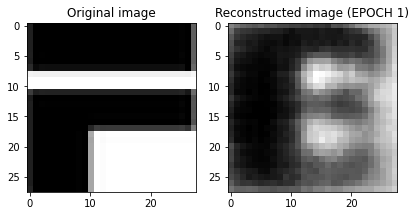

EPOCH: 2/50
	 TRAINING - EPOCH 2/50 - loss: 0.069089
	 VALIDATION - EPOCH 2/50 - loss: 0.068856


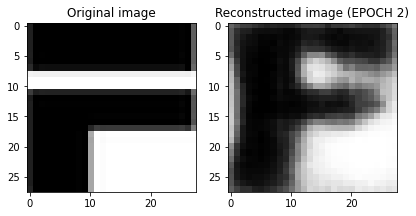

EPOCH: 3/50
	 TRAINING - EPOCH 3/50 - loss: 0.049519
	 VALIDATION - EPOCH 3/50 - loss: 0.050998


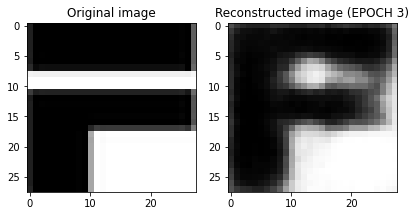

EPOCH: 4/50
	 TRAINING - EPOCH 4/50 - loss: 0.042712
	 VALIDATION - EPOCH 4/50 - loss: 0.044095


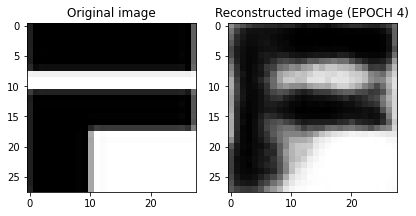

EPOCH: 5/50
	 TRAINING - EPOCH 5/50 - loss: 0.039884
	 VALIDATION - EPOCH 5/50 - loss: 0.039160


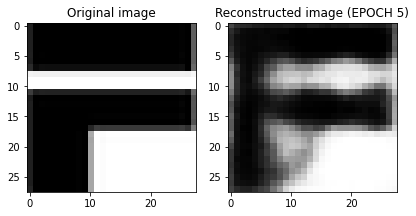

EPOCH: 6/50
	 TRAINING - EPOCH 6/50 - loss: 0.033949
	 VALIDATION - EPOCH 6/50 - loss: 0.035318


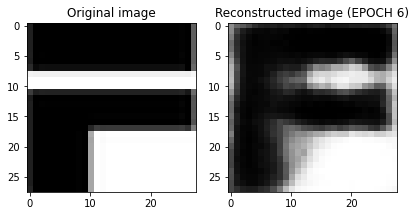

EPOCH: 7/50
	 TRAINING - EPOCH 7/50 - loss: 0.036022
	 VALIDATION - EPOCH 7/50 - loss: 0.035043


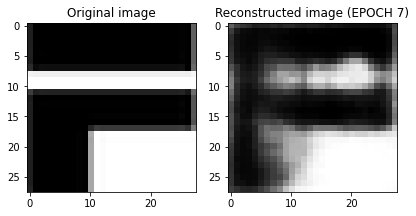

EPOCH: 8/50
	 TRAINING - EPOCH 8/50 - loss: 0.036852
	 VALIDATION - EPOCH 8/50 - loss: 0.032412


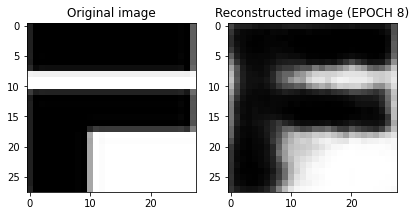

EPOCH: 9/50
	 TRAINING - EPOCH 9/50 - loss: 0.027597
	 VALIDATION - EPOCH 9/50 - loss: 0.031702


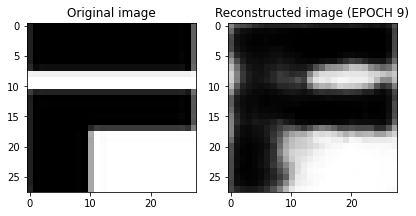

EPOCH: 10/50
	 TRAINING - EPOCH 10/50 - loss: 0.031676
	 VALIDATION - EPOCH 10/50 - loss: 0.031840


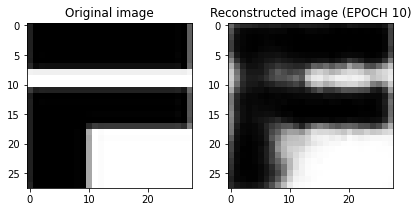

EPOCH: 11/50
	 TRAINING - EPOCH 11/50 - loss: 0.027723
	 VALIDATION - EPOCH 11/50 - loss: 0.030443


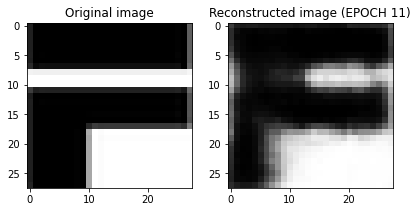

EPOCH: 12/50
	 TRAINING - EPOCH 12/50 - loss: 0.027746
	 VALIDATION - EPOCH 12/50 - loss: 0.030642


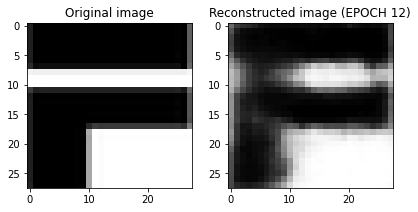

EPOCH: 13/50
	 TRAINING - EPOCH 13/50 - loss: 0.030417
	 VALIDATION - EPOCH 13/50 - loss: 0.030161


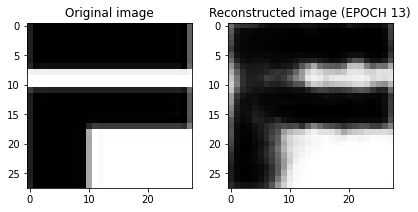

EPOCH: 14/50
	 TRAINING - EPOCH 14/50 - loss: 0.031185
	 VALIDATION - EPOCH 14/50 - loss: 0.029730


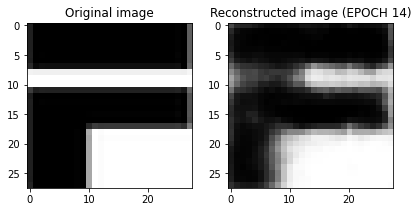

EPOCH: 15/50
	 TRAINING - EPOCH 15/50 - loss: 0.032742
	 VALIDATION - EPOCH 15/50 - loss: 0.039499


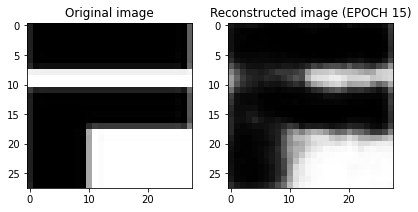

EPOCH: 16/50
	 TRAINING - EPOCH 16/50 - loss: 0.033686
	 VALIDATION - EPOCH 16/50 - loss: 0.029955


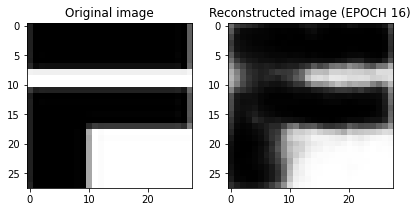

EPOCH: 17/50
	 TRAINING - EPOCH 17/50 - loss: 0.024713
	 VALIDATION - EPOCH 17/50 - loss: 0.029052


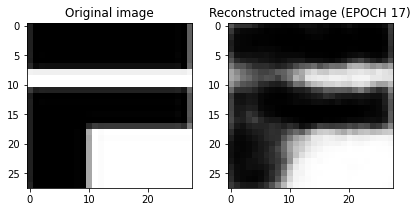

EPOCH: 18/50
	 TRAINING - EPOCH 18/50 - loss: 0.029908
	 VALIDATION - EPOCH 18/50 - loss: 0.030508


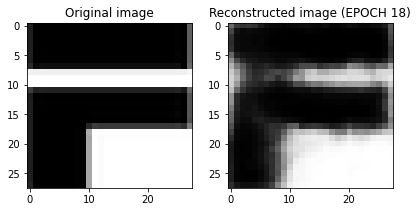

EPOCH: 19/50
	 TRAINING - EPOCH 19/50 - loss: 0.026430
	 VALIDATION - EPOCH 19/50 - loss: 0.028779


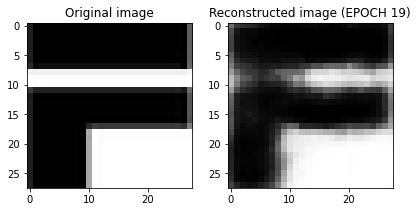

EPOCH: 20/50
	 TRAINING - EPOCH 20/50 - loss: 0.026596
	 VALIDATION - EPOCH 20/50 - loss: 0.028369


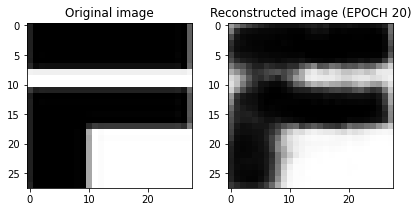

EPOCH: 21/50
	 TRAINING - EPOCH 21/50 - loss: 0.024256
	 VALIDATION - EPOCH 21/50 - loss: 0.028406


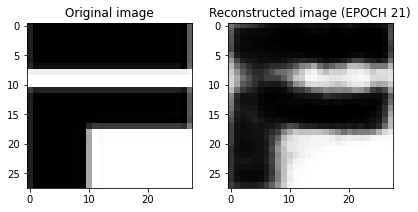

EPOCH: 22/50
	 TRAINING - EPOCH 22/50 - loss: 0.028574
	 VALIDATION - EPOCH 22/50 - loss: 0.028373


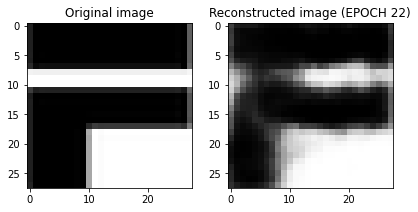

EPOCH: 23/50
	 TRAINING - EPOCH 23/50 - loss: 0.022601
	 VALIDATION - EPOCH 23/50 - loss: 0.028022


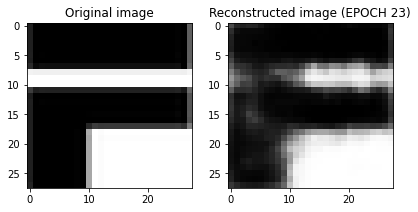

EPOCH: 24/50
	 TRAINING - EPOCH 24/50 - loss: 0.031546
	 VALIDATION - EPOCH 24/50 - loss: 0.029331


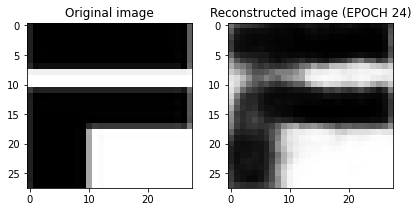

EPOCH: 25/50
	 TRAINING - EPOCH 25/50 - loss: 0.024856
	 VALIDATION - EPOCH 25/50 - loss: 0.027798


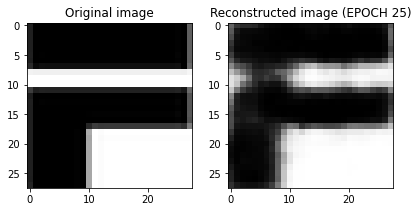

EPOCH: 26/50
	 TRAINING - EPOCH 26/50 - loss: 0.024002
	 VALIDATION - EPOCH 26/50 - loss: 0.027546


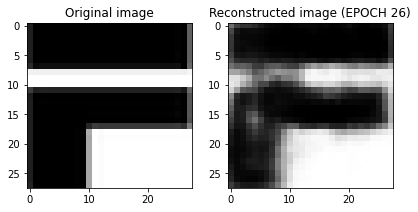

EPOCH: 27/50
	 TRAINING - EPOCH 27/50 - loss: 0.018969
	 VALIDATION - EPOCH 27/50 - loss: 0.027837


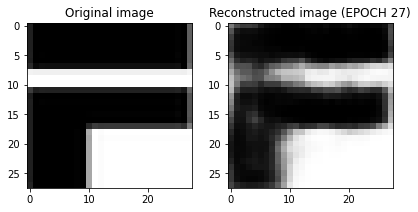

EPOCH: 28/50
	 TRAINING - EPOCH 28/50 - loss: 0.025957
	 VALIDATION - EPOCH 28/50 - loss: 0.027238


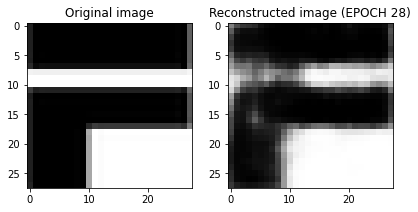

EPOCH: 29/50
	 TRAINING - EPOCH 29/50 - loss: 0.024186
	 VALIDATION - EPOCH 29/50 - loss: 0.028329


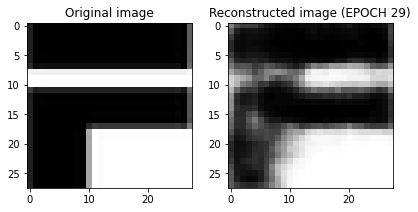

EPOCH: 30/50
	 TRAINING - EPOCH 30/50 - loss: 0.025797
	 VALIDATION - EPOCH 30/50 - loss: 0.028943


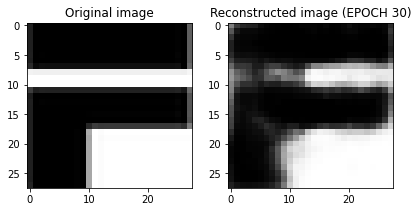

EPOCH: 31/50
	 TRAINING - EPOCH 31/50 - loss: 0.019414
	 VALIDATION - EPOCH 31/50 - loss: 0.027037


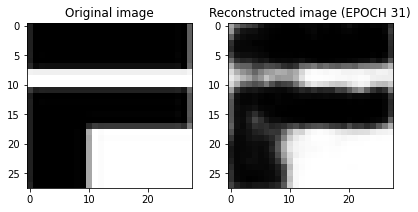

EPOCH: 32/50
	 TRAINING - EPOCH 32/50 - loss: 0.025705
	 VALIDATION - EPOCH 32/50 - loss: 0.027980


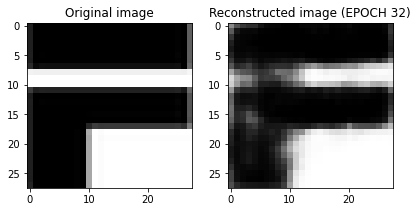

EPOCH: 33/50
	 TRAINING - EPOCH 33/50 - loss: 0.019386
	 VALIDATION - EPOCH 33/50 - loss: 0.027069


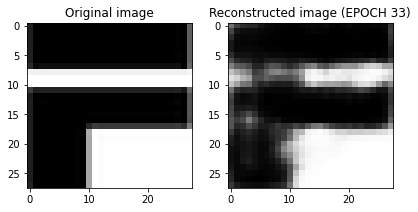

EPOCH: 34/50
	 TRAINING - EPOCH 34/50 - loss: 0.020284
	 VALIDATION - EPOCH 34/50 - loss: 0.028828


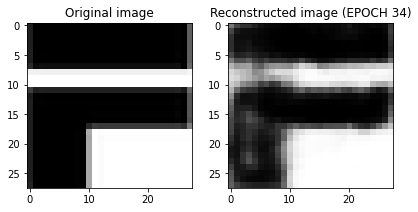

EPOCH: 35/50
	 TRAINING - EPOCH 35/50 - loss: 0.026577
	 VALIDATION - EPOCH 35/50 - loss: 0.027092


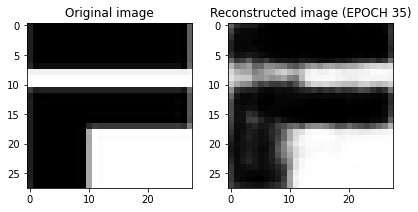

EPOCH: 36/50
	 TRAINING - EPOCH 36/50 - loss: 0.026023
	 VALIDATION - EPOCH 36/50 - loss: 0.027266


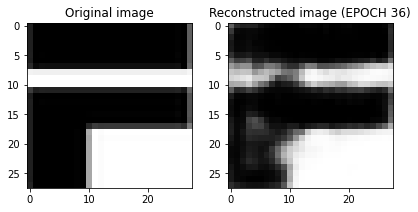

EPOCH: 37/50
	 TRAINING - EPOCH 37/50 - loss: 0.028978
	 VALIDATION - EPOCH 37/50 - loss: 0.027481


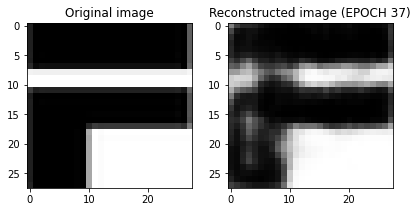

EPOCH: 38/50
	 TRAINING - EPOCH 38/50 - loss: 0.025084
	 VALIDATION - EPOCH 38/50 - loss: 0.026599


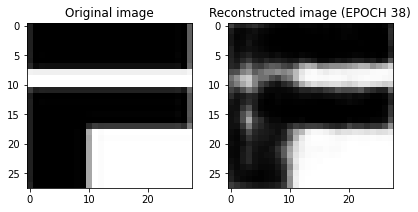

EPOCH: 39/50
	 TRAINING - EPOCH 39/50 - loss: 0.027465
	 VALIDATION - EPOCH 39/50 - loss: 0.028246


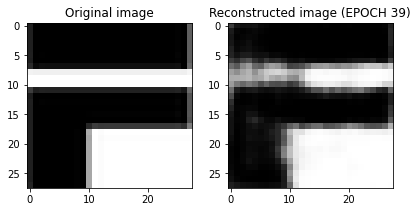

EPOCH: 40/50
	 TRAINING - EPOCH 40/50 - loss: 0.017629
	 VALIDATION - EPOCH 40/50 - loss: 0.027637


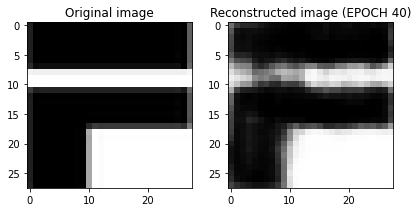

EPOCH: 41/50
	 TRAINING - EPOCH 41/50 - loss: 0.023964
	 VALIDATION - EPOCH 41/50 - loss: 0.027813


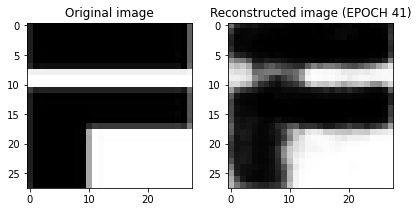

EPOCH: 42/50
	 TRAINING - EPOCH 42/50 - loss: 0.021324
	 VALIDATION - EPOCH 42/50 - loss: 0.026710


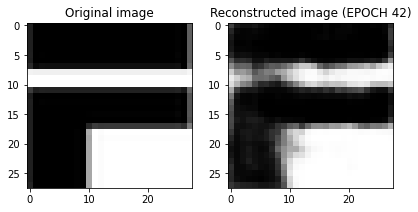

EPOCH: 43/50
	 TRAINING - EPOCH 43/50 - loss: 0.017522
	 VALIDATION - EPOCH 43/50 - loss: 0.027326


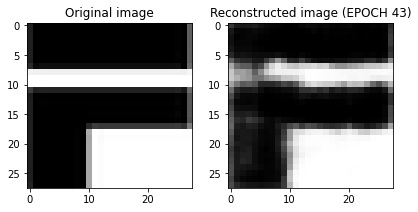

EPOCH: 44/50
	 TRAINING - EPOCH 44/50 - loss: 0.021163
	 VALIDATION - EPOCH 44/50 - loss: 0.027068


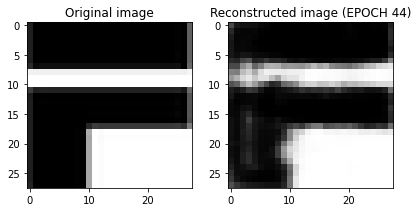

EPOCH: 45/50
	 TRAINING - EPOCH 45/50 - loss: 0.026215
	 VALIDATION - EPOCH 45/50 - loss: 0.028799


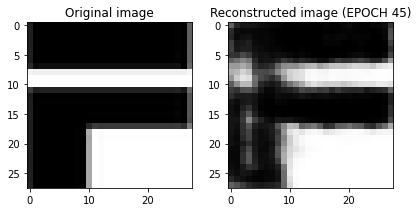

EPOCH: 46/50
	 TRAINING - EPOCH 46/50 - loss: 0.018696
	 VALIDATION - EPOCH 46/50 - loss: 0.027332


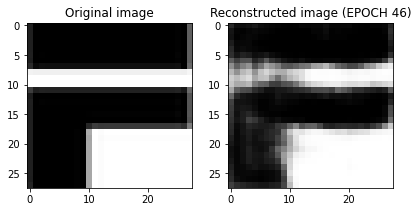

EPOCH: 47/50
	 TRAINING - EPOCH 47/50 - loss: 0.020821
	 VALIDATION - EPOCH 47/50 - loss: 0.027181


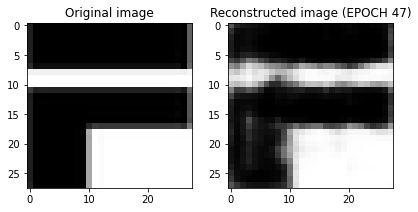

EPOCH: 48/50
	 TRAINING - EPOCH 48/50 - loss: 0.021084
	 VALIDATION - EPOCH 48/50 - loss: 0.026588


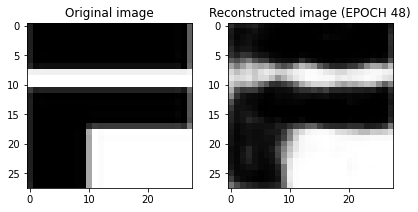

EPOCH: 49/50
	 TRAINING - EPOCH 49/50 - loss: 0.023278
	 VALIDATION - EPOCH 49/50 - loss: 0.027154


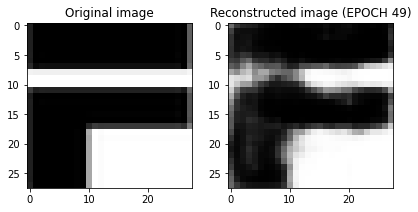

EPOCH: 50/50
	 TRAINING - EPOCH 50/50 - loss: 0.018785
	 VALIDATION - EPOCH 50/50 - loss: 0.027183


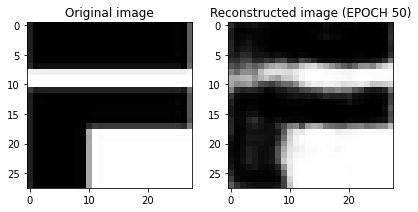

In [16]:
encoded_space_dim = best_params['encoded_space_dim']
batch_size = best_params['batch_size']
lr = best_params['lr']
optim = best_params['optim']

conv1_ch = best_params['conv1_ch']
conv2_ch = best_params['conv2_ch']
conv3_ch = best_params['conv3_ch']
fc_ch = best_params['fc_ch']

#make dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# initialize models
encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
if optim == 'Adam':
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
elif optim == 'RMSprop':
    optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)


# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


# Training Loop
display = True
num_epochs = 50

train_loss_record = []
val_loss_record = []
for epoch in range(num_epochs):
    
    print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

    train_loss_batch_record = []
    val_loss_batch_record = []
    ### Training (use the training function)
    train_loss_batch = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    train_loss_batch_record.append(train_loss_batch)
    ### Validation  (use the testing function)
    val_loss_batch = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    val_loss_batch_record.append(val_loss_batch)
    if display:
    # Print Validationloss
        print('\t TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, 
                                                                sum(train_loss_batch_record)/len(train_loss_batch_record)))
        print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss_batch))

    #store losses for this epoch
    train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
    val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))

    if display:
        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(6,3))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)


Final test loss: 0.02718348056077957


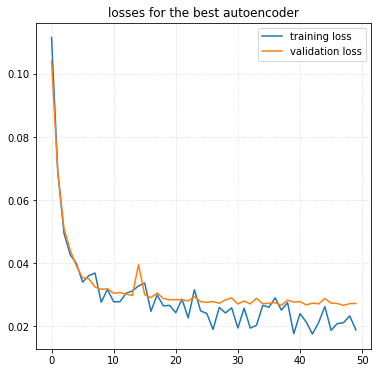

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(train_loss_record, label='training loss')
ax.plot(val_loss_record, label='validation loss')
ax.legend()
ax.grid(linestyle=":", color='lightgray')
ax.set_title("losses for the best autoencoder")
print(f"Final test loss: {val_loss_record[-1]}")

In [18]:
enc_path = "/content/drive/MyDrive/UNI_ICT/NNDL/NNDL_hw2_models/Best_Encoder.torch"
dec_path = "/content/drive/MyDrive/UNI_ICT/NNDL/NNDL_hw2_models/Best_decoder.torch"

In [19]:
# Save the state dict to a file
torch.save(encoder.state_dict(), enc_path)
torch.save(decoder.state_dict(), dec_path)

In [20]:
# Load models
encoded_space_dim = best_params['encoded_space_dim']
conv1_ch = best_params['conv1_ch']
conv2_ch = best_params['conv2_ch']
conv3_ch = best_params['conv3_ch']
fc_ch = best_params['fc_ch']
encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)


# encoder.load_state_dict(torch.load(enc_path))
# decoder.load_state_dict(torch.load(dec_path))
encoder.load_state_dict(torch.load(enc_path, map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(dec_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [21]:
best_encoder = encoder
best_decoder = decoder

## Examples of reconstructed samples

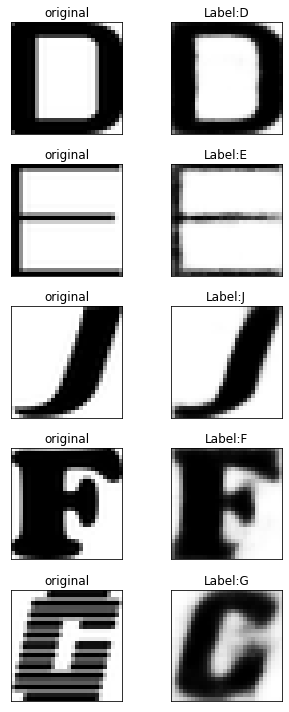

In [ ]:
rows = 5
fig, ax = plt.subplots(5, 2, figsize=(rows,rows*2))
for i in range(rows):
    img, label = random.choice(test_dataset)
    img = img.unsqueeze(0).to(device)
    best_encoder.eval()
    best_decoder.eval()
    with torch.no_grad():
        rec_img  = best_decoder(best_encoder(img))
    ax[i,0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
    ax[i,0].set_title('original')
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
    ax[i,1].set_title(f'Label:{letter[label]}' )
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
plt.tight_layout()

## Latent space analysis

Generation of encoded samples

In [ ]:
### Get the encoded representation of the test samples
def make_encoded_samples(dataset, encoder, device):
    encoded_samples = []
    for sample in tqdm(dataset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = letter[label]
        encoded_samples.append(encoded_sample)
    
    return encoded_samples

In [ ]:
encoded_samples = make_encoded_samples(test_dataset, best_encoder, device)

# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples

100%|██████████| 3745/3745 [00:03<00:00, 978.48it/s]


## PCA if dim > 2

In [ ]:
if encoded_space_dim > 2:
    PCAobj = PCA(n_components=2)
    PCAobj.fit(encoded_samples.iloc[:,0:encoded_space_dim])
    encoded_samples_reduced = PCAobj.transform(encoded_samples.iloc[:,0:encoded_space_dim])

    encoded_samples_reduced = pd.DataFrame(encoded_samples_reduced)
    # encoded_samples_reduced.insert(encoded_space_dim, "label", encoded_samples["label"], True)
    encoded_samples_reduced['label'] = encoded_samples['label']
    encoded_samples_reduced.columns = ['Enc. Variable 0', 'Enc. Variable 1', 'label']
    encoded_samples_reduced

    # print(PCAobj.explained_variance_ratio_)
    # print(type(encoded_samples_reduced))
    # print(np.shape(encoded_samples_reduced))
else:
    encoded_samples_reduced = encoded_samples
    print("no need for PCA")
    

In [ ]:
encoded_samples_reduced.head()

,Enc. Variable 0,Enc. Variable 1,label
0,3.300896,5.294589,F
1,-11.719869,-2.960314,H
2,-15.388217,13.067252,H
3,-12.591936,10.442175,G
4,-5.275185,6.743850,D


Unluckily, since the best models for our dataset have a latent space with dimension very greater than 2, this visualization is not very informative.

In [ ]:
import plotly.express as px
px.scatter(encoded_samples_reduced, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

# PART 2 Denoising autoencoder

torch.Size([256, 1, 28, 28])


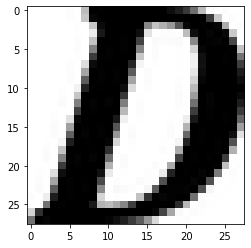

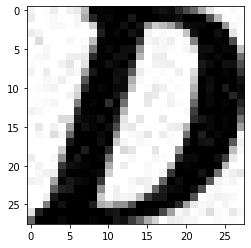

In [ ]:

dataloader = DataLoader(test_dataset, 256, shuffle=False)
image_batch, _ = next(iter(dataloader))
noise = torch.Tensor(np.random.normal(0,0.05, (np.shape(image_batch)[0],1,28,28)))

print(np.shape(image_batch))
plt.figure()
plt.imshow(image_batch[0].squeeze().numpy(), cmap='gray_r')

image_batch += noise
image_batch = torch.clip(image_batch, 0, 1)
plt.figure()
plt.imshow(image_batch[0].squeeze().numpy(), cmap='gray_r')

We inject gaussian noise before the loading of the sample, need to define a new training step that use noise. For the evaluation function we use the same used before

In [ ]:
### Training function WITH NOISE INJECTION
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        #-----------inject gaussian noise------------
        noise = torch.Tensor(np.random.normal(0,0.05, (np.shape(image_batch)[0],1,28,28)))
        image_batch +=noise
        image_batch = torch.clip(image_batch, 0, 1)


        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    
    return loss.data

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Parameters search with Optuna

we need to put the training loop in the level of the objective function, and not as another function, in order to have a functioning trial.report used for pruning

In [ ]:
def objective(trial):

    #suggest parameters
    encoded_space_dim = trial.suggest_int('encoded_space_dim', 2,10)
    batch_size = trial.suggest_int('batch_size', 200, 1000)
    optim = trial.suggest_categorical('optim', ['Adam', 'RMSprop'])
    conv1_ch = trial.suggest_categorical('conv1_ch', [32,64,128])
    conv2_ch = trial.suggest_categorical('conv2_ch', [32,64,128])
    conv3_ch = trial.suggest_categorical('conv3_ch', [32,64,128])
    fc_ch = trial.suggest_categorical('fc_ch', [32,64,128])
    
    #make dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # initialize models
    encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
    decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    if optim == 'Adam':
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
    elif optim == 'RMSprop':
        optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)
    
    
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)


    # Training Loop
    display = False
    num_epochs = 50 #just smoke test

    train_loss_record = []
    val_loss_record = []
    for epoch in notebook.tqdm(range(num_epochs)):
        if display:
            print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

        train_loss_batch_record = []
        val_loss_batch_record = []
        ### Training (use the training function)
        train_loss_batch = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_batch_record.append(train_loss_batch)
        ### Validation  (use the testing function)
        val_loss_batch = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        val_loss_batch_record.append(val_loss_batch)
        if display:
        # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                    sum(train_loss_batch_record)/len(train_loss_batch_record)))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

        #store losses for this epoch
        train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
        val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))

        if display:
            ### Plot progress
            # Get the output of a specific image (the test image at index 0 in this case)
            img = test_dataset[0][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img  = decoder(encoder(img))
            # Plot the reconstructed image
            fig, axs = plt.subplots(1, 2, figsize=(6,3))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            plt.pause(0.1)


        # call back optuna for pruning
        trial.report(sum(val_loss_batch_record)/len(val_loss_batch_record), epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        #end of training loop
    
    final_val_loss = val_loss_record[-1]
    

    
    return final_val_loss

Create study and perform the search

In [ ]:
study = optuna.create_study(direction='minimize', 
                            pruner=optuna.pruners.MedianPruner(
                                n_startup_trials=5, n_warmup_steps=5, interval_steps=1))
study.optimize(objective, n_trials=100)

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2020-12-22 18:05:57,641] A new study created in memory with name: no-name-f06f570e-33af-416b-b003-14627a1e3cdb


[I 2020-12-22 18:07:49,509] Trial 0 finished with value: 0.045978158712387085 and parameters: {'encoded_space_dim': 6, 'batch_size': 302, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0004487204758327569}. Best is trial 0 with value: 0.045978158712387085.


[I 2020-12-22 18:09:27,493] Trial 1 finished with value: 0.0632690042257309 and parameters: {'encoded_space_dim': 9, 'batch_size': 830, 'optim': 'RMSprop', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.0002640572661162429}. Best is trial 0 with value: 0.045978158712387085.


[I 2020-12-22 18:11:15,490] Trial 2 finished with value: 0.04941892251372337 and parameters: {'encoded_space_dim': 5, 'batch_size': 984, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 64, 'lr': 0.011204411632505185}. Best is trial 0 with value: 0.045978158712387085.


[I 2020-12-22 18:12:56,271] Trial 3 finished with value: 0.4383881688117981 and parameters: {'encoded_space_dim': 7, 'batch_size': 477, 'optim': 'RMSprop', 'conv1_ch': 32, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.05963313860247535}. Best is trial 0 with value: 0.045978158712387085.


[I 2020-12-22 18:14:40,610] Trial 4 finished with value: 0.05117020383477211 and parameters: {'encoded_space_dim': 7, 'batch_size': 888, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 32, 'lr': 0.0006120594741966386}. Best is trial 0 with value: 0.045978158712387085.


[I 2020-12-22 18:14:51,659] Trial 5 pruned. 


[I 2020-12-22 18:15:09,383] Trial 6 pruned. 


[I 2020-12-22 18:15:21,194] Trial 7 pruned. 


[I 2020-12-22 18:15:40,171] Trial 8 pruned. 


[I 2020-12-22 18:17:27,051] Trial 9 finished with value: 0.03964429721236229 and parameters: {'encoded_space_dim': 10, 'batch_size': 629, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.020672161996129028}. Best is trial 9 with value: 0.03964429721236229.


[I 2020-12-22 18:17:39,307] Trial 10 pruned. 


[I 2020-12-22 18:17:51,436] Trial 11 pruned. 


[I 2020-12-22 18:18:29,362] Trial 12 pruned. 


[I 2020-12-22 18:18:40,757] Trial 13 pruned. 


[I 2020-12-22 18:18:52,777] Trial 14 pruned. 


[I 2020-12-22 18:19:25,608] Trial 15 pruned. 


[I 2020-12-22 18:20:54,052] Trial 16 pruned. 


[I 2020-12-22 18:22:32,753] Trial 17 finished with value: 0.042823027819395065 and parameters: {'encoded_space_dim': 8, 'batch_size': 724, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.0034038419077525345}. Best is trial 9 with value: 0.03964429721236229.


[I 2020-12-22 18:24:12,556] Trial 18 finished with value: 0.0403335839509964 and parameters: {'encoded_space_dim': 9, 'batch_size': 759, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.002560952490766881}. Best is trial 9 with value: 0.03964429721236229.


[I 2020-12-22 18:25:51,640] Trial 19 finished with value: 0.03907904401421547 and parameters: {'encoded_space_dim': 10, 'batch_size': 750, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.0017309325782076494}. Best is trial 19 with value: 0.03907904401421547.


[I 2020-12-22 18:26:03,789] Trial 20 pruned. 


[I 2020-12-22 18:26:15,887] Trial 21 pruned. 


[I 2020-12-22 18:26:27,765] Trial 22 pruned. 


[I 2020-12-22 18:28:05,164] Trial 23 finished with value: 0.040685053914785385 and parameters: {'encoded_space_dim': 8, 'batch_size': 565, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.002964630618774509}. Best is trial 19 with value: 0.03907904401421547.


[I 2020-12-22 18:28:17,143] Trial 24 pruned. 


[I 2020-12-22 18:29:55,159] Trial 25 finished with value: 0.03745238855481148 and parameters: {'encoded_space_dim': 10, 'batch_size': 562, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.005623535804837986}. Best is trial 25 with value: 0.03745238855481148.


[I 2020-12-22 18:30:07,016] Trial 26 pruned. 


[I 2020-12-22 18:31:21,637] Trial 27 pruned. 


[I 2020-12-22 18:33:03,352] Trial 28 finished with value: 0.031352315098047256 and parameters: {'encoded_space_dim': 10, 'batch_size': 663, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0052465836197560945}. Best is trial 28 with value: 0.031352315098047256.


[I 2020-12-22 18:34:45,739] Trial 29 finished with value: 0.03694014251232147 and parameters: {'encoded_space_dim': 7, 'batch_size': 396, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.006003475247621401}. Best is trial 28 with value: 0.031352315098047256.


[I 2020-12-22 18:36:26,200] Trial 30 finished with value: 0.037706535309553146 and parameters: {'encoded_space_dim': 7, 'batch_size': 392, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005097265324621872}. Best is trial 28 with value: 0.031352315098047256.


[I 2020-12-22 18:38:08,888] Trial 31 finished with value: 0.036400292068719864 and parameters: {'encoded_space_dim': 7, 'batch_size': 370, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0068170603231246215}. Best is trial 28 with value: 0.031352315098047256.


[I 2020-12-22 18:38:48,802] Trial 32 pruned. 


[I 2020-12-22 18:40:29,206] Trial 33 finished with value: 0.04017166048288345 and parameters: {'encoded_space_dim': 7, 'batch_size': 407, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.010073667157013405}. Best is trial 28 with value: 0.031352315098047256.


[I 2020-12-22 18:42:10,457] Trial 34 finished with value: 0.035290684551000595 and parameters: {'encoded_space_dim': 8, 'batch_size': 538, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.008253445854953823}. Best is trial 28 with value: 0.031352315098047256.


[I 2020-12-22 18:42:22,725] Trial 35 pruned. 


[I 2020-12-22 18:44:03,341] Trial 36 finished with value: 0.039185866713523865 and parameters: {'encoded_space_dim': 7, 'batch_size': 421, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.013797755501352602}. Best is trial 28 with value: 0.031352315098047256.


[I 2020-12-22 18:45:12,945] Trial 37 pruned. 


[I 2020-12-22 18:45:24,991] Trial 38 pruned. 


[I 2020-12-22 18:47:05,425] Trial 39 finished with value: 0.037547092884778976 and parameters: {'encoded_space_dim': 7, 'batch_size': 516, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.007926133224882049}. Best is trial 28 with value: 0.031352315098047256.


[I 2020-12-22 18:47:17,582] Trial 40 pruned. 


[I 2020-12-22 18:47:29,890] Trial 41 pruned. 


[I 2020-12-22 18:49:10,119] Trial 42 finished with value: 0.03225437551736832 and parameters: {'encoded_space_dim': 9, 'batch_size': 576, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.004289992416153925}. Best is trial 28 with value: 0.031352315098047256.


[I 2020-12-22 18:50:49,350] Trial 43 finished with value: 0.03129470348358154 and parameters: {'encoded_space_dim': 9, 'batch_size': 599, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.003829940242077032}. Best is trial 43 with value: 0.03129470348358154.


[I 2020-12-22 18:52:31,213] Trial 44 finished with value: 0.033600687980651855 and parameters: {'encoded_space_dim': 9, 'batch_size': 613, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.009460968385616829}. Best is trial 43 with value: 0.03129470348358154.


[I 2020-12-22 18:54:11,666] Trial 45 finished with value: 0.03207441046833992 and parameters: {'encoded_space_dim': 9, 'batch_size': 609, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.003972291707008713}. Best is trial 43 with value: 0.03129470348358154.


[I 2020-12-22 18:55:50,722] Trial 46 finished with value: 0.03225802630186081 and parameters: {'encoded_space_dim': 9, 'batch_size': 617, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.004044181471805652}. Best is trial 43 with value: 0.03129470348358154.


[I 2020-12-22 18:56:01,956] Trial 47 pruned. 


[I 2020-12-22 18:56:13,885] Trial 48 pruned. 


[I 2020-12-22 18:56:25,914] Trial 49 pruned. 


[I 2020-12-22 18:56:37,835] Trial 50 pruned. 


[I 2020-12-22 18:58:15,985] Trial 51 finished with value: 0.03295565024018288 and parameters: {'encoded_space_dim': 9, 'batch_size': 620, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.009513941958842037}. Best is trial 43 with value: 0.03129470348358154.


[I 2020-12-22 18:58:28,067] Trial 52 pruned. 


[I 2020-12-22 18:58:39,690] Trial 53 pruned. 


[I 2020-12-22 18:58:51,054] Trial 54 pruned. 


[I 2020-12-22 18:59:02,864] Trial 55 pruned. 


[I 2020-12-22 18:59:15,247] Trial 56 pruned. 


[I 2020-12-22 19:00:54,935] Trial 57 finished with value: 0.032704830169677734 and parameters: {'encoded_space_dim': 9, 'batch_size': 592, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.011035490075377054}. Best is trial 43 with value: 0.03129470348358154.


[I 2020-12-22 19:01:06,773] Trial 58 pruned. 


[I 2020-12-22 19:01:25,124] Trial 59 pruned. 


[I 2020-12-22 19:01:37,227] Trial 60 pruned. 


[I 2020-12-22 19:03:15,962] Trial 61 finished with value: 0.03264674171805382 and parameters: {'encoded_space_dim': 9, 'batch_size': 627, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.011277165543502424}. Best is trial 43 with value: 0.03129470348358154.


[I 2020-12-22 19:03:33,437] Trial 62 pruned. 


[I 2020-12-22 19:03:45,332] Trial 63 pruned. 


[I 2020-12-22 19:05:24,729] Trial 64 finished with value: 0.031569745391607285 and parameters: {'encoded_space_dim': 10, 'batch_size': 550, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0113485112722904}. Best is trial 43 with value: 0.03129470348358154.


[I 2020-12-22 19:05:37,301] Trial 65 pruned. 


[I 2020-12-22 19:07:16,387] Trial 66 finished with value: 0.030534295365214348 and parameters: {'encoded_space_dim': 10, 'batch_size': 539, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0027636868293029826}. Best is trial 66 with value: 0.030534295365214348.


[I 2020-12-22 19:08:56,162] Trial 67 finished with value: 0.030417220667004585 and parameters: {'encoded_space_dim': 10, 'batch_size': 536, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0028521317827190215}. Best is trial 67 with value: 0.030417220667004585.


[I 2020-12-22 19:09:08,169] Trial 68 pruned. 


[I 2020-12-22 19:09:20,080] Trial 69 pruned. 


[I 2020-12-22 19:10:58,929] Trial 70 finished with value: 0.031189028173685074 and parameters: {'encoded_space_dim': 10, 'batch_size': 476, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0017834203695381177}. Best is trial 67 with value: 0.030417220667004585.


[I 2020-12-22 19:12:36,890] Trial 71 finished with value: 0.03154265880584717 and parameters: {'encoded_space_dim': 10, 'batch_size': 462, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0018457689451089575}. Best is trial 67 with value: 0.030417220667004585.


[I 2020-12-22 19:12:50,783] Trial 72 pruned. 


[I 2020-12-22 19:13:02,668] Trial 73 pruned. 


[I 2020-12-22 19:13:14,446] Trial 74 pruned. 


[I 2020-12-22 19:14:53,900] Trial 75 finished with value: 0.030976006761193275 and parameters: {'encoded_space_dim': 10, 'batch_size': 542, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0025538415792367188}. Best is trial 67 with value: 0.030417220667004585.


[I 2020-12-22 19:15:05,808] Trial 76 pruned. 


[I 2020-12-22 19:15:17,615] Trial 77 pruned. 


[I 2020-12-22 19:16:56,115] Trial 78 finished with value: 0.029887711629271507 and parameters: {'encoded_space_dim': 10, 'batch_size': 550, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0030127813448170655}. Best is trial 78 with value: 0.029887711629271507.


[I 2020-12-22 19:17:07,694] Trial 79 pruned. 


[I 2020-12-22 19:18:46,949] Trial 80 finished with value: 0.029662765562534332 and parameters: {'encoded_space_dim': 10, 'batch_size': 504, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0026487944823199764}. Best is trial 80 with value: 0.029662765562534332.


[I 2020-12-22 19:20:27,171] Trial 81 finished with value: 0.03013201802968979 and parameters: {'encoded_space_dim': 10, 'batch_size': 517, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0028558024398601446}. Best is trial 80 with value: 0.029662765562534332.


[I 2020-12-22 19:22:08,056] Trial 82 finished with value: 0.03004274144768715 and parameters: {'encoded_space_dim': 10, 'batch_size': 515, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002730316113731052}. Best is trial 80 with value: 0.029662765562534332.


[I 2020-12-22 19:23:47,836] Trial 83 finished with value: 0.029050806537270546 and parameters: {'encoded_space_dim': 10, 'batch_size': 518, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002621624811004465}. Best is trial 83 with value: 0.029050806537270546.


[I 2020-12-22 19:25:28,463] Trial 84 finished with value: 0.03300018236041069 and parameters: {'encoded_space_dim': 10, 'batch_size': 520, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0028152757097750338}. Best is trial 83 with value: 0.029050806537270546.


[I 2020-12-22 19:27:10,103] Trial 85 finished with value: 0.03068172000348568 and parameters: {'encoded_space_dim': 10, 'batch_size': 492, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0025567686740657356}. Best is trial 83 with value: 0.029050806537270546.


[I 2020-12-22 19:28:49,314] Trial 86 finished with value: 0.029131421819329262 and parameters: {'encoded_space_dim': 10, 'batch_size': 501, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0025995565988198477}. Best is trial 83 with value: 0.029050806537270546.


[I 2020-12-22 19:30:30,496] Trial 87 finished with value: 0.028628405183553696 and parameters: {'encoded_space_dim': 10, 'batch_size': 505, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.003301244567030449}. Best is trial 87 with value: 0.028628405183553696.


[I 2020-12-22 19:30:44,652] Trial 88 pruned. 


[I 2020-12-22 19:32:25,095] Trial 89 finished with value: 0.03011283278465271 and parameters: {'encoded_space_dim': 10, 'batch_size': 512, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0012421583105180004}. Best is trial 87 with value: 0.028628405183553696.


[I 2020-12-22 19:32:36,652] Trial 90 pruned. 


[I 2020-12-22 19:32:49,217] Trial 91 pruned. 


[I 2020-12-22 19:33:01,506] Trial 92 pruned. 


[I 2020-12-22 19:34:41,170] Trial 93 finished with value: 0.02880748175084591 and parameters: {'encoded_space_dim': 10, 'batch_size': 445, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0022231368180841704}. Best is trial 87 with value: 0.028628405183553696.


[I 2020-12-22 19:36:20,667] Trial 94 finished with value: 0.028725583106279373 and parameters: {'encoded_space_dim': 10, 'batch_size': 425, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0022049947344241127}. Best is trial 87 with value: 0.028628405183553696.


[I 2020-12-22 19:37:59,543] Trial 95 finished with value: 0.028858227655291557 and parameters: {'encoded_space_dim': 10, 'batch_size': 418, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002229144477013036}. Best is trial 87 with value: 0.028628405183553696.


[I 2020-12-22 19:39:41,029] Trial 96 finished with value: 0.029282111674547195 and parameters: {'encoded_space_dim': 10, 'batch_size': 417, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0022162782324024084}. Best is trial 87 with value: 0.028628405183553696.


[I 2020-12-22 19:41:22,019] Trial 97 finished with value: 0.029318688437342644 and parameters: {'encoded_space_dim': 10, 'batch_size': 409, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0021759899513141222}. Best is trial 87 with value: 0.028628405183553696.


[I 2020-12-22 19:43:04,494] Trial 98 finished with value: 0.029613176360726357 and parameters: {'encoded_space_dim': 10, 'batch_size': 383, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0015797946498288947}. Best is trial 87 with value: 0.028628405183553696.


[I 2020-12-22 19:44:47,671] Trial 99 finished with value: 0.029495149850845337 and parameters: {'encoded_space_dim': 9, 'batch_size': 378, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0021710519414076196}. Best is trial 87 with value: 0.028628405183553696.



val Loss: 0.028628405183553696
Best hyperparameters: {'encoded_space_dim': 10, 'batch_size': 505, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.003301244567030449}


In [ ]:
best_params_denoise = trial.params
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_conv1_ch,params_conv2_ch,params_conv3_ch,params_encoded_space_dim,params_fc_ch,params_lr,params_optim,state
0,0,0.045978,2020-12-22 18:05:57.643912,2020-12-22 18:07:49.508344,0 days 00:01:51.864432,302,128,32,64,6,128,0.000449,Adam,COMPLETE
1,1,0.063269,2020-12-22 18:07:49.510358,2020-12-22 18:09:27.492768,0 days 00:01:37.982410,830,64,128,32,9,128,0.000264,RMSprop,COMPLETE
2,2,0.049419,2020-12-22 18:09:27.499146,2020-12-22 18:11:15.489649,0 days 00:01:47.990503,984,128,128,32,5,64,0.011204,Adam,COMPLETE
3,3,0.438388,2020-12-22 18:11:15.493353,2020-12-22 18:12:56.270756,0 days 00:01:40.777403,477,32,128,128,7,64,0.059633,RMSprop,COMPLETE
4,4,0.051170,2020-12-22 18:12:56.279114,2020-12-22 18:14:40.609711,0 days 00:01:44.330597,888,32,128,128,7,32,0.000612,Adam,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.028858,2020-12-22 19:36:20.675009,2020-12-22 19:37:59.543055,0 days 00:01:38.868046,418,64,64,128,10,128,0.002229,Adam,COMPLETE
96,96,0.029282,2020-12-22 19:37:59.547542,2020-12-22 19:39:41.029109,0 days 00:01:41.481567,417,64,64,128,10,128,0.002216,Adam,COMPLETE
97,97,0.029319,2020-12-22 19:39:41.032044,2020-12-22 19:41:22.018857,0 days 00:01:40.986813,409,64,64,128,10,128,0.002176,Adam,COMPLETE
98,98,0.029613,2020-12-22 19:41:22.027003,2020-12-22 19:43:04.493751,0 days 00:01:42.466748,383,64,64,128,10,128,0.001580,Adam,COMPLETE


## Optuna search visualization

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

## Training of the best model

save the trial dataframe

In [ ]:
csv_name = 'optuna100x50_denoise'
json_name = 'optuna100x50_best_params_denoise'
file_path = '/content/drive/MyDrive/UNI_ICT/NNDL/NNDL_hw2_data/'

In [ ]:
import json
trials_df.to_csv(file_path+csv_name)

json_file = json.dumps(best_params_denoise)
f = open(file_path+json_name, "w")
f.write(json_file)
f.close()

or load the trial dataframe and best parameters

In [18]:
trials_df = pd.read_csv(file_path+csv_name)
with open(file_path+json_name) as json_file:
    best_params_denoise = json.load(json_file)

print(best_params_denoise)

{'encoded_space_dim': 10, 'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0033638691442384257}


visualization optuna

train a model with the best parameters

In [32]:
encoded_space_dim = best_params_denoise['encoded_space_dim']
batch_size = best_params_denoise['batch_size']
lr = best_params_denoise['lr']
optim = best_params_denoise['optim']

conv1_ch = best_params_denoise['conv1_ch']
conv2_ch = best_params_denoise['conv2_ch']
conv3_ch = best_params_denoise['conv3_ch']
fc_ch = best_params_denoise['fc_ch']

#make dataloaders
#train with the test set this time
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# initialize models
encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
if optim == 'Adam':
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
elif optim == 'RMSprop':
    optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)


# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


# Training Loop
display = True
num_epochs = 50

train_loss_record = []
val_loss_record = []
for epoch in range(num_epochs):
    
    print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

    train_loss_batch_record = []
    val_loss_batch_record = []
    ### Training (use the training function)
    train_loss_batch = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    train_loss_batch_record.append(train_loss_batch)
    ### Validation  (use the testing function)
    val_loss_batch = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    val_loss_batch_record.append(val_loss_batch)
    if display:
    # Print Validationloss
        print('\t TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, 
                                                                sum(train_loss_batch_record)/len(train_loss_batch_record)))
        print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss_batch))

    #store losses for this epoch
    train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
    val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))

    if display:
        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(6,3))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)


NameError: ignored

Final test loss: 0.028264665976166725


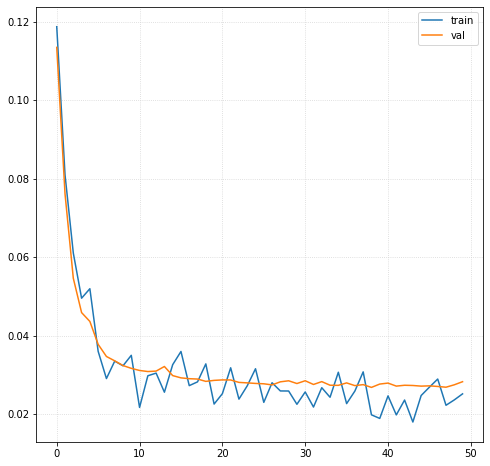

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(train_loss_record, label='train')
ax.plot(val_loss_record, label='val')
ax.legend()
ax.grid(linestyle=":", color='lightgray')

print(f"Final test loss: {val_loss_record[-1]}")

In [ ]:
best_encoder_denoise = encoder
best_decoder_denoise = decoder

## Examples of reconstructed noisy samples

---



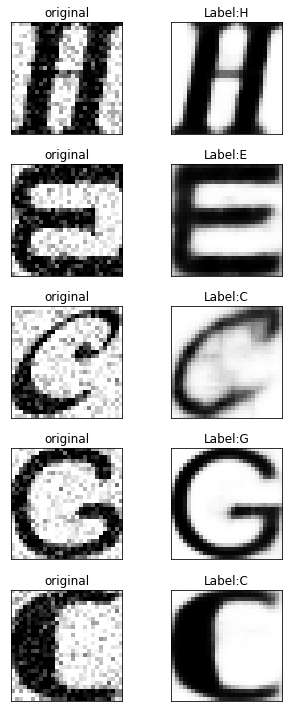

In [ ]:
rows = 5
fig, ax = plt.subplots(5, 2, figsize=(rows,rows*2))
for i in range(rows):
    img, label = random.choice(test_dataset)
    #need to test dimesions 
    noise = torch.Tensor(np.random.normal(0,0.2, (28,28)))
    img +=noise
    img = torch.clip(img, 0, 1)

    img = img.unsqueeze(0).to(device)

    best_encoder_denoise.eval()
    best_decoder_denoise.eval()
    with torch.no_grad():
        rec_img  = best_decoder(best_encoder(img))
    ax[i,0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
    ax[i,0].set_title('original')
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
    ax[i,1].set_title(f'Label:{letter[label]}' )
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
plt.tight_layout()

## Latent space analysis

Generation of encoded samples

In [ ]:
### Get the encoded representation of the test samples
def make_encoded_samples(dataset, encoder, device):
    encoded_samples = []
    for sample in tqdm(dataset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = letter[label]
        encoded_samples.append(encoded_sample)
    
    return encoded_samples

In [ ]:
encoded_samples = make_encoded_samples(test_dataset, best_encoder_denoise, device)
print(type(encoded_samples))
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples

100%|██████████| 3745/3745 [00:02<00:00, 1431.54it/s]

<class 'list'>


maybe remove pca now

## PCA if dim > 2

In [ ]:
if encoded_space_dim > 2:
    PCAobj = PCA(n_components=2)
    PCAobj.fit(encoded_samples.iloc[:,0:encoded_space_dim])
    encoded_samples_reduced = PCAobj.transform(encoded_samples.iloc[:,0:encoded_space_dim])

    encoded_samples_reduced = pd.DataFrame(encoded_samples_reduced)
    # encoded_samples_reduced.insert(encoded_space_dim, "label", encoded_samples["label"], True)
    encoded_samples_reduced['label'] = encoded_samples['label']
    encoded_samples_reduced.columns = ['Enc. Variable 0', 'Enc. Variable 1', 'label']
    encoded_samples_reduced

    # print(PCAobj.explained_variance_ratio_)
    # print(type(encoded_samples_reduced))
    # print(np.shape(encoded_samples_reduced))
else:
    encoded_samples_reduced = encoded_samples
    print("no need for PCA")
    

In [ ]:
encoded_samples_reduced.head()

,Enc. Variable 0,Enc. Variable 1,label
0,3.300896,5.294589,F
1,-11.719869,-2.960314,H
2,-15.388217,13.067252,H
3,-12.591936,10.442175,G
4,-5.275185,6.743850,D


Unluckily, since the best models for our dataset have a latent space with dimension very greater than 2, this visualization is not very informative.

In [ ]:
import plotly.express as px
px.scatter(encoded_samples_reduced, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

# Part 3 Classification on encoded samples

Let's reconsider the original autoencoder

## Built compressed dataset.
We need to build a dataset of encoded samples

In [22]:
### Get the encoded representation of the test samples
# it is modified wrt before in order to give two lists as output
def make_encoded_samples(dataset, encoder, device):
    encoded_samples = []
    label_list = []
    encoder = encoder.to(device)
    for sample in notebook.tqdm(dataset):
        img = sample[0].unsqueeze(0).to(device)
        label_list.append(sample[1])
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        # Append to list
        # encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_img = encoded_img.cpu().numpy()
        encoded_samples.append(encoded_img)
    
    return encoded_samples, label_list

encoded_images, labels = make_encoded_samples(dataset, best_encoder, device)

Make a new Dataset object with encoded images

In [23]:
print(labels)
print(len(labels))
print(type(encoded_images[0]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [24]:
class NMDataset(Dataset):

    def __init__(self, image, label, transform=None):
        self.transform = transform
        self.image = image
        self.label = label

    def __len__(self):
        return len(self.image)


    def __getitem__(self, idx):
        this_image = self.image[idx]
        this_label = self.label[idx]
        sample = [this_image, this_label]
        if self.transform:
            sample = self.transform(sample)
        return sample


    # class ToTensor(object):
    #     """Convert sample to Tensors."""

    #     def __call__(self, sample):
    #         x, y = sample
    #         return (torch.tensor([x]).float(),
    #                 torch.tensor([y]).float())

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor(x).squeeze().float(),
                torch.Tensor([y]).long())

In [25]:
to_tensor = ToTensor()
encoded_dataset = NMDataset(encoded_images, labels, transform=to_tensor)
print(len(encoded_dataset))
print(np.shape(encoded_dataset[2000][0]))
print(np.shape(encoded_dataset[2000][1]))
print(type(encoded_dataset[1][1]))
# everything ok here mmmh


18724
torch.Size([10])
torch.Size([1])
<class 'torch.Tensor'>


Divide training and validation 

In [26]:
length = dataset.__len__()
testval_size = int(np.ceil(length*0.4))
train_size = int(length-testval_size)
train_dataset, test_dataset = torch.utils.data.random_split(encoded_dataset, [train_size, testval_size])

test_size = int(np.ceil(test_dataset.__len__()*0.5))
val_size = int(test_dataset.__len__()-test_size)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

print(f"train_dataset length {train_dataset.__len__()}")
print(f"val_dataset length {val_dataset.__len__()}")
print(f"test_dataset length {test_dataset.__len__()}")

train_dataset length 11234
val_dataset length 3745
test_dataset length 3745


## Build a simple Classifier

In [27]:
class EncodedClassifier(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, Nh3):

        super().__init__()

        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=10)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)   #check softmax dimension
        
    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.out(x))
        return x

# net = EncodedClassifier(10, 16,32,32)
# inp = torch.Tensor(np.arange(10)).unsqueeze(0).unsqueeze(0)
# print(np.shape(inp))
# print(net(inp))

## Training with Optuna search

In [42]:

# def training_loop(net, optimizer, loss_fn, train_dataloader, val_dataloader, n_epochs, verbose=False):
def objective(trial):
    
    fc1_ch = trial.suggest_int('fc1_ch', 16, 64)
    fc2_ch = trial.suggest_int('fc2_ch', 16, 64)
    fc3_ch = trial.suggest_int('fc3_ch', 16, 64)
    batch_size = trial.suggest_int("batch_size", 100, 1000)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    verbose = False

    loss_fn = nn.CrossEntropyLoss()
    net = EncodedClassifier(10, fc1_ch, fc2_ch, fc3_ch)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

    
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []

    n_epochs = 30
    for epoch_num in notebook.tqdm(range(n_epochs)):
        if verbose:
            print(f'EPOCH {epoch_num}')

        #training step
        train_loss = []
        train_acc = []
        net.train()
        for sample_batched in train_dataloader:
            
            x_batch = sample_batched[0].to(device)
            # print(np.shape(x_batch))
            
            # label_batch = sample_batched[1].squeeze().to(device=device, dtype=torch.long)
            label_batch = sample_batched[1].squeeze().to(device)

            #forward
            out = net(x_batch)

            #compute loss
            loss = loss_fn(out, label_batch)

            #backpropagation
            net.zero_grad()
            loss.backward()

            #update weights
            optimizer.step()

            #save train loss
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

            #compute accuracy in the batch
            _, predicted = torch.max(out, 1)
            correct = (predicted == label_batch).sum().item()
            acc_batch = correct/label_batch.size(0)
            train_acc.append(acc_batch)


        #save average train loss and accuracy
        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)
        if verbose:
            print(f"train loss: {train_loss}")
            print(f"train accuracy: {train_acc}")
        train_loss_log.append(train_loss)   
        train_acc_log.append(train_acc) 

        #validation
        val_loss= []
        val_acc = []
        correct = 0
        net.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].squeeze().to(device)

                # Forward pass
                out = net(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

                #compute accuracy in the batch
                _, predicted = torch.max(out, 1)
                correct = (predicted == label_batch).sum().item()
                acc_batch = correct/label_batch.size(0)
                val_acc.append(acc_batch)
                

            # Save average validation  and accuracy
            val_acc = np.mean(val_acc)
            val_loss = np.mean(val_loss)
            if verbose:
                print(f"validation loss: {val_loss}")
                print(f"validation accuracy: {val_acc}")
            val_loss_log.append(val_loss)
            val_acc_log.append(val_acc)  


        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_acc_log[-1]

In [43]:
study = optuna.create_study(direction='maximize', 
                            pruner=optuna.pruners.MedianPruner(
                                n_startup_trials=5, n_warmup_steps=5, interval_steps=1))
study.optimize(objective, n_trials=50)

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2021-01-10 21:52:14,801] A new study created in memory with name: no-name-ad02e9d7-bdcd-4edd-b94e-6bdbc7e950a6


[I 2021-01-10 21:52:25,646] Trial 0 finished with value: 0.8963951935914553 and parameters: {'fc1_ch': 58, 'fc2_ch': 23, 'fc3_ch': 59, 'batch_size': 962, 'lr': 0.004821432323144303}. Best is trial 0 with value: 0.8963951935914553.


[I 2021-01-10 21:52:37,302] Trial 1 finished with value: 0.757543391188251 and parameters: {'fc1_ch': 62, 'fc2_ch': 59, 'fc3_ch': 43, 'batch_size': 612, 'lr': 5.949733337260187e-05}. Best is trial 0 with value: 0.8963951935914553.


[I 2021-01-10 21:52:52,901] Trial 2 finished with value: 0.8336448598130841 and parameters: {'fc1_ch': 29, 'fc2_ch': 28, 'fc3_ch': 58, 'batch_size': 219, 'lr': 5.067197995398856e-05}. Best is trial 0 with value: 0.8963951935914553.


[I 2021-01-10 21:53:06,994] Trial 3 finished with value: 0.897196261682243 and parameters: {'fc1_ch': 56, 'fc2_ch': 43, 'fc3_ch': 26, 'batch_size': 297, 'lr': 0.0023865616372347955}. Best is trial 3 with value: 0.897196261682243.


[I 2021-01-10 21:53:17,905] Trial 4 finished with value: 0.8005340453938585 and parameters: {'fc1_ch': 47, 'fc2_ch': 64, 'fc3_ch': 43, 'batch_size': 966, 'lr': 0.00025583752169313766}. Best is trial 3 with value: 0.897196261682243.


[I 2021-01-10 21:53:18,300] Trial 5 pruned. 


[I 2021-01-10 21:53:40,967] Trial 6 finished with value: 0.794392523364486 and parameters: {'fc1_ch': 57, 'fc2_ch': 50, 'fc3_ch': 31, 'batch_size': 101, 'lr': 0.00011802518599568681}. Best is trial 3 with value: 0.897196261682243.


[I 2021-01-10 21:53:41,500] Trial 7 pruned. 


[I 2021-01-10 21:53:56,878] Trial 8 finished with value: 0.8518024032042724 and parameters: {'fc1_ch': 17, 'fc2_ch': 17, 'fc3_ch': 62, 'batch_size': 228, 'lr': 0.009970285120280776}. Best is trial 3 with value: 0.897196261682243.


[I 2021-01-10 21:54:08,861] Trial 9 finished with value: 0.8878504672897196 and parameters: {'fc1_ch': 31, 'fc2_ch': 38, 'fc3_ch': 25, 'batch_size': 527, 'lr': 0.00914903967215897}. Best is trial 3 with value: 0.897196261682243.


[I 2021-01-10 21:54:21,585] Trial 10 finished with value: 0.9001335113484646 and parameters: {'fc1_ch': 45, 'fc2_ch': 52, 'fc3_ch': 17, 'batch_size': 411, 'lr': 0.0018263185631044734}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:54:22,042] Trial 11 pruned. 


[I 2021-01-10 21:54:22,487] Trial 12 pruned. 


[I 2021-01-10 21:54:22,935] Trial 13 pruned. 


[I 2021-01-10 21:54:35,017] Trial 14 finished with value: 0.8931909212283045 and parameters: {'fc1_ch': 52, 'fc2_ch': 59, 'fc3_ch': 22, 'batch_size': 518, 'lr': 0.0036668048711437614}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:54:56,684] Trial 15 finished with value: 0.8870493991989319 and parameters: {'fc1_ch': 63, 'fc2_ch': 33, 'fc3_ch': 33, 'batch_size': 109, 'lr': 0.003482521675525397}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:54:57,264] Trial 16 pruned. 


[I 2021-01-10 21:54:57,662] Trial 17 pruned. 


[I 2021-01-10 21:54:58,143] Trial 18 pruned. 


[I 2021-01-10 21:55:10,481] Trial 19 finished with value: 0.8958611481975968 and parameters: {'fc1_ch': 26, 'fc2_ch': 64, 'fc3_ch': 20, 'batch_size': 465, 'lr': 0.006045849590759153}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:55:11,095] Trial 20 pruned. 


[I 2021-01-10 21:55:11,566] Trial 21 pruned. 


[I 2021-01-10 21:55:22,935] Trial 22 finished with value: 0.7975967957276369 and parameters: {'fc1_ch': 60, 'fc2_ch': 21, 'fc3_ch': 29, 'batch_size': 635, 'lr': 0.009152520415987504}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:55:23,421] Trial 23 pruned. 


[I 2021-01-10 21:55:23,862] Trial 24 pruned. 


[I 2021-01-10 21:55:37,498] Trial 25 finished with value: 0.8929238985313752 and parameters: {'fc1_ch': 49, 'fc2_ch': 28, 'fc3_ch': 37, 'batch_size': 314, 'lr': 0.005265306177439918}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:55:37,893] Trial 26 pruned. 


[I 2021-01-10 21:55:38,300] Trial 27 pruned. 


[I 2021-01-10 21:55:38,747] Trial 28 pruned. 


[I 2021-01-10 21:55:39,467] Trial 29 pruned. 


[I 2021-01-10 21:55:39,877] Trial 30 pruned. 


[I 2021-01-10 21:55:40,314] Trial 31 pruned. 


[I 2021-01-10 21:55:40,769] Trial 32 pruned. 


[I 2021-01-10 21:55:41,263] Trial 33 pruned. 


[I 2021-01-10 21:55:41,665] Trial 34 pruned. 


[I 2021-01-10 21:55:54,020] Trial 35 finished with value: 0.8942590120160213 and parameters: {'fc1_ch': 26, 'fc2_ch': 28, 'fc3_ch': 59, 'batch_size': 483, 'lr': 0.004043694121583084}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:55:54,457] Trial 36 pruned. 


[I 2021-01-10 21:55:54,912] Trial 37 pruned. 


[I 2021-01-10 21:55:55,318] Trial 38 pruned. 


[I 2021-01-10 21:55:55,842] Trial 39 pruned. 


[I 2021-01-10 21:56:12,678] Trial 40 finished with value: 0.8891855807743658 and parameters: {'fc1_ch': 19, 'fc2_ch': 53, 'fc3_ch': 45, 'batch_size': 184, 'lr': 0.0027962213205945177}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:56:13,105] Trial 41 pruned. 


[I 2021-01-10 21:56:25,304] Trial 42 finished with value: 0.8785046728971962 and parameters: {'fc1_ch': 28, 'fc2_ch': 23, 'fc3_ch': 57, 'batch_size': 484, 'lr': 0.008510632156528062}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:56:25,744] Trial 43 pruned. 


[I 2021-01-10 21:56:37,813] Trial 44 finished with value: 0.8998664886515354 and parameters: {'fc1_ch': 33, 'fc2_ch': 29, 'fc3_ch': 59, 'batch_size': 506, 'lr': 0.0038251737388086005}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:56:49,761] Trial 45 finished with value: 0.8859813084112149 and parameters: {'fc1_ch': 32, 'fc2_ch': 30, 'fc3_ch': 52, 'batch_size': 520, 'lr': 0.009609684780805263}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:57:01,388] Trial 46 finished with value: 0.8929238985313752 and parameters: {'fc1_ch': 50, 'fc2_ch': 25, 'fc3_ch': 63, 'batch_size': 600, 'lr': 0.006069398189754052}. Best is trial 10 with value: 0.9001335113484646.


[I 2021-01-10 21:57:01,991] Trial 47 pruned. 


[I 2021-01-10 21:57:02,439] Trial 48 pruned. 


[I 2021-01-10 21:57:02,857] Trial 49 pruned. 


val Loss: 0.9001335113484646
Best hyperparameters: {'fc1_ch': 45, 'fc2_ch': 52, 'fc3_ch': 17, 'batch_size': 411, 'lr': 0.0018263185631044734}


In [44]:
classifier_best_params = {'fc1_ch': 45, 'fc2_ch': 52, 'fc3_ch': 17, 'batch_size': 411, 'lr': 0.0018263185631044734}

## Training classifier with best parameters

In [49]:

#smoke run 
fc1_ch = classifier_best_params['fc1_ch']
fc2_ch = classifier_best_params['fc2_ch']
fc3_ch = classifier_best_params['fc3_ch']
batch_size = classifier_best_params['batch_size']
lr = classifier_best_params['lr']

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#use test dataset
val_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

verbose = False

loss_fn = nn.CrossEntropyLoss()
net = EncodedClassifier(10, fc1_ch, fc2_ch, fc3_ch)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

train_loss_log = []
train_acc_log = []
val_loss_log = []
val_acc_log = []

n_epochs = 30 
for epoch_num in notebook.tqdm(range(n_epochs)):
    if verbose:
        print(f'EPOCH {epoch_num}')

    #training step
    train_loss = []
    train_acc = []
    net.train()
    for sample_batched in train_dataloader:
        
        x_batch = sample_batched[0].to(device)
        # print(np.shape(x_batch))
        
        # label_batch = sample_batched[1].squeeze().to(device=device, dtype=torch.long)
        label_batch = sample_batched[1].squeeze().to(device)

        #forward
        out = net(x_batch)

        #compute loss
        loss = loss_fn(out, label_batch)

        #backpropagation
        net.zero_grad()
        loss.backward()

        #update weights
        optimizer.step()

        #save train loss
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

        #compute accuracy in the batch
        _, predicted = torch.max(out, 1)
        correct = (predicted == label_batch).sum().item()
        acc_batch = correct/label_batch.size(0)
        train_acc.append(acc_batch)


    #save average train loss and accuracy
    train_loss = np.mean(train_loss)
    train_acc = np.mean(train_acc)
    if verbose:
        print(f"train loss: {train_loss}")
        print(f"train accuracy: {train_acc}")
    train_loss_log.append(train_loss)   
    train_acc_log.append(train_acc) 

    #validation
    val_loss= []
    val_acc = []
    correct = 0
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].squeeze().to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

            #compute accuracy in the batch
            _, predicted = torch.max(out, 1)
            correct = (predicted == label_batch).sum().item()
            acc_batch = correct/label_batch.size(0)
            val_acc.append(acc_batch)
            

        # Save average validation  and accuracy
        val_acc = np.mean(val_acc)
        val_loss = np.mean(val_loss)
        if verbose:
            print(f"validation loss: {val_loss}")
            print(f"validation accuracy: {val_acc}")
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)  


Final training accuracy: 0.8958611481975968
Final training loss: 1.5658429861068726


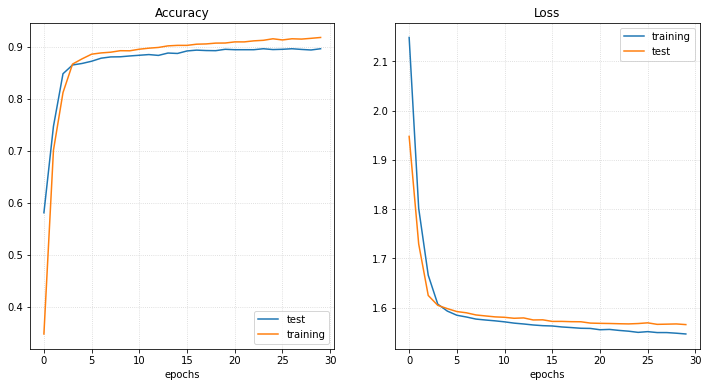

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title("Accuracy")
ax2.set_title("Loss")
# ax.semilogy(train_loss_log, label="training")
ax1.plot(val_acc_log, label="test")
ax1.plot(train_acc_log, label='training')
ax2.plot(train_loss_log, label='training')
ax2.plot(val_loss_log, label='test')
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')

ax1.set_xlabel("epochs")

ax2.set_xlabel("epochs")

ax1.legend()
ax2.legend()

fig.show()

print(f'Final training accuracy: {val_acc_log[-1]}')
print(f'Final training loss: {val_loss_log[-1]}')